In [2]:
import sys
sys.path.insert(0, '..\src\data')
#import make_dataset_beta as md
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans
from scipy.spatial.distance import cdist
import pandas as pd
import cv2

In [6]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import svm
from sklearn.svm import SVC, SVR
import os
import cv2

In [4]:
mypath = "C:/Users/User/Desktop/CUNY/Faces_img/cropped.tar/cropped/crop_part1"

In [7]:
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath +'/' + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns)
filedfnona = filedf.dropna()
filedfnona['age']  = filedfnona['age'].astype(int)
filedfnona['race'] = filedfnona['race'].astype(int)
filedfnona['gender'] = filedfnona['gender'].astype(int)

In [33]:
filedfnona['gender']

0       1
1       1
2       1
3       0
4       0
       ..
9773    1
9774    1
9775    1
9776    1
9777    1
Name: gender, Length: 9778, dtype: int32

In [8]:
images = []
for img_path in filedfnona['file']:
    image = plt.imread(img_path)
    images.append(image) 

In [9]:
X_img = np.array(images)

In [3]:
# Get Image Descriptors, which are a combination of points on an image and the description of surrounding pixels.

def get_descriptors(nparrays,nfeatures):
    sift = cv2.SIFT_create(nfeatures = nfeatures)
    container = []
    for i in nparrays:
        img_bw = i
        if(len(i.shape)==3):
            img_bw = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        keypoint,descriptor = sift.detectAndCompute(img_bw,None)
        container.append([keypoint,descriptor])
    return container

#For a collection of image area descriptions, get the Kmeans of n clusters. This will be what future images are compared to.

def get_vocab(descriptors,n):
    descriptor_container = []
    for i in descriptors:
        if i[1] is None:
            continue
        for j in i[1]:
            descriptor_container.append(j)
    vocab = kmeans(descriptor_container,n)
    return vocab

# For each image, get its descriptors. For each descriptor, get the closest Kmean descriptor in vocab and add 1 to its index in a histogram.
# Return a histogram per image. This histogram will be passed as a feature for modeling.

def descriptor_to_vocab(nparrays,vocab):
    sift = cv2.SIFT_create()
    container = []
    for i in nparrays:
        
        img_bw = i
        if(len(i.shape)==3):
            img_bw = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        keypoint,descriptor = sift.detectAndCompute(img_bw,None)
        if descriptor is not None:
            dist = cdist(descriptor,vocab[0],'euclidean')
            bin_assignment = np.argmin(dist,axis = 1)
        else:
            bin_assignment = []
        image_feats = np.zeros(len(vocab[0]))
        for j in bin_assignment:
            image_feats[j] += 1
        container.append(image_feats)
    return container

# Normalizes histograms from images so that they may be used in ML inputs

def normalize_histograms(histarray):
    histarray = np.array(histarray)
    feats_norm_div = np.linalg.norm(histarray,axis = 1)
    for i in range(0,histarray.shape[0]):
        divi = feats_norm_div[i]
        histarray[i] = histarray[i]/divi
        if(np.isnan(histarray[i][0])):
            histarray[i] = np.zeros(len(histarray[i]))
    return histarray

# Pipeline for SIFT to histogram features per image
# Returns a dataframe for training and testing datasets
'''
path - path to the image directory
column - what type of label to return
nvocab - how many vectors will appear in the descriptor 'vocabulary'
test_size - percentage of images that will be used as tests
random_state - seed for randomization
n_features - For each image, return at most n descriptors
'''



# X[:,0] should be file names and X[:,1] should be nparrays of images

def SIFT_nparray_to_Features(X_train,X_test,nvocab = 200,n_features = 100):
    X_train_np = np.array(X_train)
    X_test_np = np.array(X_test)
    descriptors = get_descriptors(X_train_np,n_features)
    vocab = get_vocab(descriptors[:100],nvocab)
    histarraytrain = descriptor_to_vocab(X_train_np,vocab)
    histarraytest = descriptor_to_vocab(X_test_np,vocab)
    normalizehisttrain = normalize_histograms(histarraytrain)
    normalizehisttest = normalize_histograms(histarraytest)
    nonantrain = np.nan_to_num(normalizehisttrain)
    nonantest = np.nan_to_num(normalizehisttest)
    return nonantrain,nonantest



In [10]:
#gender
X_train, X_test, y_train, y_test = train_test_split(X_img, filedfnona['gender'], test_size=0.33, random_state=42)

In [11]:
X_train_sift,X_test_sift = SIFT_nparray_to_Features(X_train, X_test)

C:\Users\User\AppData\Local\Temp/ipykernel_9524/2970605708.py:56: RuntimeWarning: invalid value encountered in true_divide
  histarray[i] = histarray[i]/divi


In [13]:
X_scaled=X_train_sift/255.0
X_test_sc=X_test_sift/255.0

In [17]:
model = SVC(kernel = 'linear', C=1.0, random_state=42, verbose = True)

In [18]:
model.fit(X_scaled, y_train)

[LibSVM]

SVC(kernel='linear', random_state=42, verbose=True)

In [19]:
y_pred_gender = model.predict(X_scaled)

In [20]:
print(f"accuracy: {accuracy_score(y_train, y_pred_gender)}")
print(f"{classification_report(y_train, y_pred_gender)}")

accuracy: 0.5541138757441612
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2921
           1       0.55      1.00      0.71      3630

    accuracy                           0.55      6551
   macro avg       0.28      0.50      0.36      6551
weighted avg       0.31      0.55      0.40      6551



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
y_pred_test_gender = model.predict(X_test_sc)
print(f"accuracy: {accuracy_score(y_test, y_pred_test_gender)}")
print(f"{classification_report(y_test, y_pred_test_gender)}")

accuracy: 0.5503563681437867
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1451
           1       0.55      1.00      0.71      1776

    accuracy                           0.55      3227
   macro avg       0.28      0.50      0.35      3227
weighted avg       0.30      0.55      0.39      3227



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Heatmap for gender')

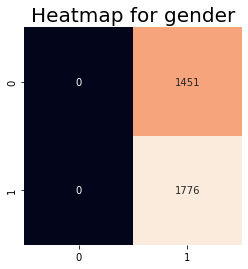

In [22]:
mat = metrics.confusion_matrix(y_test, y_pred_test_gender)
sns.heatmap(mat, square = True, annot=True, fmt = 'd', cbar = False)
plt.title('Heatmap for gender', size = 20)

In [23]:
# Sift race
X_train_sift_race, X_test_sift_race, y_train_sift_race, y_test_sift_race = train_test_split(X_img, filedfnona['race'], test_size=0.33, random_state=42)

In [24]:
X_train_sift_race,X_test_sift_race = SIFT_nparray_to_Features(X_train_sift_race, X_test_sift_race)

C:\Users\User\AppData\Local\Temp/ipykernel_9524/2970605708.py:56: RuntimeWarning: invalid value encountered in true_divide
  histarray[i] = histarray[i]/divi


In [25]:
X_scaled_race=X_train_sift_race/255.0
X_test_sc_race=X_test_sift_race/255.0

In [46]:
model_race = SVC(kernel = 'linear', C=1.0, random_state=42, verbose = True)

In [47]:
model_race.fit(X_scaled_race, y_train_sift_race)

[LibSVM]

SVC(kernel='linear', random_state=42, verbose=True)

In [48]:
y_pred_race = model_race.predict(X_scaled_race)

In [49]:
print(f"accuracy: {accuracy_score(y_train_sift_race, y_pred_race)}")
print(f"{classification_report(y_train_sift_race, y_pred_race)}")

accuracy: 0.5380857884292475
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      3525
           1       0.00      0.00      0.00       281
           2       0.00      0.00      0.00      1035
           3       0.00      0.00      0.00       955
           4       0.00      0.00      0.00       755

    accuracy                           0.54      6551
   macro avg       0.11      0.20      0.14      6551
weighted avg       0.29      0.54      0.38      6551



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
y_pred_test_race = model_race.predict(X_test_sc_race)
print(f"accuracy: {accuracy_score(y_test_sift_race, y_pred_test_race)}")
print(f"{classification_report(y_test_sift_race, y_pred_test_race)}")

accuracy: 0.5392004958165478
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1740
           1       0.00      0.00      0.00       124
           2       0.00      0.00      0.00       518
           3       0.00      0.00      0.00       497
           4       0.00      0.00      0.00       348

    accuracy                           0.54      3227
   macro avg       0.11      0.20      0.14      3227
weighted avg       0.29      0.54      0.38      3227



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Heatmap for race/sift')

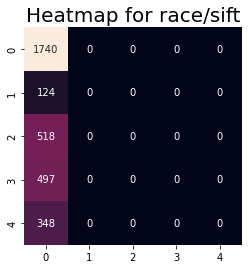

In [51]:
mat_race = metrics.confusion_matrix(y_test_sift_race, y_pred_test_race)
sns.heatmap(mat_race, square = True, annot=True, fmt = 'd', cbar = False)
plt.title('Heatmap for race/sift', size = 20)

In [52]:
filedfnona['age']=np.where((filedfnona.age==2), 1, filedfnona.age)

In [53]:
filedfnona['age']=np.where(((filedfnona.age>=3) & (filedfnona.age<6)), 2, filedfnona.age)

In [54]:
filedfnona['age']=np.where(((filedfnona.age>=6) & (filedfnona.age<9)), 3, filedfnona.age)

In [55]:
filedfnona['age']=np.where(((filedfnona.age>=9) & (filedfnona.age<12)), 4, filedfnona.age)

In [56]:
filedfnona['age']=np.where(((filedfnona.age>=12) & (filedfnona.age<21)), 5, filedfnona.age)

In [57]:
filedfnona['age']=np.where(((filedfnona.age>=21) & (filedfnona.age<36)), 6, filedfnona.age)

In [58]:
filedfnona['age']=np.where(((filedfnona.age>=36) & (filedfnona.age<51)), 7, filedfnona.age)

In [59]:
filedfnona['age']=np.where(((filedfnona.age>=51) & (filedfnona.age<80)), 8, filedfnona.age)

In [60]:
filedfnona['age']=np.where((filedfnona.age>=80), 9, filedfnona.age)

In [61]:
filedfnona['age'].value_counts()

6    2015
8    1866
1    1587
7    1213
5    1118
2     724
3     476
9     417
4     362
Name: age, dtype: int64

In [73]:
# Sift age
X_train_sift_age, X_test_sift_age, y_train_sift_age, y_test_sift_age = train_test_split(X_img, filedfnona['age'], test_size=0.33, random_state=42)

In [74]:
X_train_sift_age,X_test_sift_age = SIFT_nparray_to_Features(X_train_sift_age, X_test_sift_age)

C:\Users\User\AppData\Local\Temp/ipykernel_9524/2970605708.py:56: RuntimeWarning: invalid value encountered in true_divide
  histarray[i] = histarray[i]/divi


In [75]:
X_scaled_age=X_train_sift_age/255.0
X_test_sift_age=X_test_sift_age/255.0

In [70]:
#nimages, nX, ny, nrgb = X_test_sc_age.shape
#X_test_sc_age = X_test_sc_age.reshape((nimages,nX*ny*nrgb))

In [77]:
model_age = SVC(kernel = 'linear', C=1.0, random_state=42, verbose = True)
model_age.fit(X_scaled_age, y_train_sift_age)

[LibSVM]

SVC(kernel='linear', random_state=42, verbose=True)

In [78]:
y_pred_age = model_age.predict(X_scaled_age)
print(f"accuracy: {accuracy_score(y_train_sift_age, y_pred_age)}")
print(f"{classification_report(y_train_sift_age, y_pred_age)}")

accuracy: 0.20271714242100441
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1059
           2       0.00      0.00      0.00       490
           3       0.00      0.00      0.00       305
           4       0.00      0.00      0.00       230
           5       0.00      0.00      0.00       747
           6       0.20      1.00      0.34      1328
           7       0.00      0.00      0.00       828
           8       0.00      0.00      0.00      1274
           9       0.00      0.00      0.00       290

    accuracy                           0.20      6551
   macro avg       0.02      0.11      0.04      6551
weighted avg       0.04      0.20      0.07      6551



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
y_pred_test_age = model_age.predict(X_test_sift_age)
print(f"accuracy: {accuracy_score(y_test_sift_age, y_pred_test_age)}")
print(f"{classification_report(y_test_sift_age, y_pred_test_age)}")

accuracy: 0.2128912302448094
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       528
           2       0.00      0.00      0.00       234
           3       0.00      0.00      0.00       171
           4       0.00      0.00      0.00       132
           5       0.00      0.00      0.00       371
           6       0.21      1.00      0.35       687
           7       0.00      0.00      0.00       385
           8       0.00      0.00      0.00       592
           9       0.00      0.00      0.00       127

    accuracy                           0.21      3227
   macro avg       0.02      0.11      0.04      3227
weighted avg       0.05      0.21      0.07      3227



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Heatmap for age/sift')

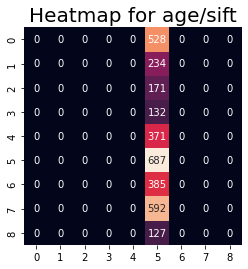

In [82]:
mat_age = metrics.confusion_matrix(y_test_sift_age, y_pred_test_age)
sns.heatmap(mat_age, square = True, annot=True, fmt = 'd', cbar = False)
plt.title('Heatmap for age/sift', size = 20)